In [27]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [28]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Molsnapper
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [29]:
uru.rd_set_image_size(300,300)

### Reading the data from Molsnapper

In [30]:
smi_list = []
with open('smi_list_molsnapper_testset.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

len(standardized_smiles_list)

849

In [31]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...
4,NC(=O)[C@@H]1NN[C@H](N)N1
...,...
844,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...
845,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...
846,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1
847,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1


Add an RDKit molecule to the dataframe

In [32]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

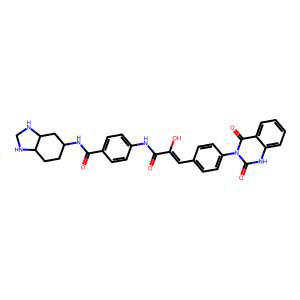

In [33]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [34]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0      [c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...
1      [O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...
2                   [O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]
3                           [c1ccccc1, C1=CC2=CC=NC2=C1]
4                                              [C1NCNN1]
                             ...                        
844             [c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]
845                                [N=C1NCCCN1, C1CCOC1]
846                                 [c1ccccc1, c1ccccc1]
847                       [c1ccccc1, c1ccccc1, c1ccncc1]
848                        [O=C1CNCc2ccccc2N1, c1ccccc1]
Name: ring_sytems, Length: 849, dtype: object

In [35]:
df.ring_sytems.values

array([list(['c1ccccc1', 'C1CCC2NCNC2C1', 'c1ccccc1', 'O=c1[nH]c(=O)c2ccccc2[nH]1']),
       list(['O=C1CCC2CCNC(=O)[C@H]2N1', 'c1ccc2c(c1)NCO2', 'c1ccccc1', 'c1ccccc1']),
       list(['O=C1C=CC=C2C(=O)N=CC=C12', 'c1ccccc1']),
       list(['c1ccccc1', 'C1=CC2=CC=NC2=C1']), list(['C1NCNN1']),
       list(['c1ccccc1', 'O=C1C=CN=N1']),
       list(['c1cncnc1', 'c1ccc2c(c1)OCCO2']),
       list(['O=c1cc[nH]cn1', 'c1ccccc1']),
       list(['c1ccccc1', 'c1ccccc1']),
       list(['c1ccccc1', 'c1ccncc1', 'c1ccccc1']),
       list(['O=C1NC(=O)N2C[C@@H]3Cn4c(nc(=O)c5ccc(=O)oc54)N3C=C12', 'O=C1CCCOc2ccccc2N1']),
       list(['C1CO1']), list(['C1CN1', 'C1CN1']),
       list(['O=C1C=CN=N1', 'c1ccc2cnccc2c1']),
       list(['c1ccccc1', 'O=C1COC2CCCCC2N1', 'C1CCCC1']),
       list(['c1ccccc1', 'c1ccccc1']), list(['C1CO[C@@H]2CCOCC[C@H]2C1']),
       list(['c1ccccc1', 'c1ccccc1']), list(['C1CNNC1', 'c1ccccc1']),
       list([]), list([]),
       list(['c1ccccc1', 'O=C1C[N@H+]2C[C@]23[C@@H]2N1CN1C(=O)N

See how many times each ring system occurs

In [36]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
0,c1ccccc1,567
12,c1ccncc1,53
55,C1CCOC1,45
15,C1CO1,34
27,c1ccoc1,29
...,...,...
153,C1CN2C[C@H]3O[C@H]3[C@@H]2O1,1
169,C1C[C@@H]2OCC[C@H]2CN1,1
168,O=C1C=CCCC1,1
167,O=C1NC[C@]2(COc3ccccc3NC2=O)N1,1


View the ring system frequencies

In [37]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [38]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [39]:
res

0      [(c1ccccc1, 2260082), (C1CCC2NCNC2C1, 7), (c1c...
1      [(O=C1CCC2CCNC(=O)[C@H]2N1, 0), (c1ccc2c(c1)NC...
2      [(O=C1C=CC=C2C(=O)N=CC=C12, 0), (c1ccccc1, 226...
3           [(c1ccccc1, 2260082), (C1=CC2=CC=NC2=C1, 0)]
4                                         [(C1NCNN1, 1)]
                             ...                        
844    [(c1ccccc1, 2260082), (c1ccccc1, 2260082), (C1...
845                [(N=C1NCCCN1, 109), (C1CCOC1, 47269)]
846           [(c1ccccc1, 2260082), (c1ccccc1, 2260082)]
847    [(c1ccccc1, 2260082), (c1ccccc1, 2260082), (c1...
848      [(O=C1CNCc2ccccc2N1, 368), (c1ccccc1, 2260082)]
Name: mol, Length: 849, dtype: object

In [40]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x749338759070>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,7
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7493349ede00>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd90>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd20>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7493349edcb0>,[C1NCNN1],C1NCNN1,1
...,...,...,...,...,...
844,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7493349b94d0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,174309
845,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7493349b9540>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,109
846,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b95b0>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082
847,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b9620>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698


In [41]:
df_ring_appearance_0 = df[df['min_freq'] == 0]
df_ring_appearance_0

,SMILES,mol,ring_sytems,min_ring,min_freq
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7493349ede00>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd90>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd20>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0
5,CCOC(=O)c1cc(N=O)c(O)c(C(=O)NC2=CC(=O)N=N2)c1,<rdkit.Chem.rdchem.Mol object at 0x7493349edc40>,"[c1ccccc1, O=C1C=CN=N1]",O=C1C=CN=N1,0
10,C=CCN1C(=O)C2=CN3c4nc(=O)c5cc(-c6ccc7c(c6)OCCC...,<rdkit.Chem.rdchem.Mol object at 0x7493349eda10>,[O=C1NC(=O)N2C[C@@H]3Cn4c(nc(=O)c5ccc(=O)oc54)...,O=C1NC(=O)N2C[C@@H]3Cn4c(nc(=O)c5ccc(=O)oc54)N...,0
...,...,...,...,...,...
828,N#C[C@@H]1C(=O)C2C(=O)C3C[C@H]4CCCCC4C[C@@H]3O...,<rdkit.Chem.rdchem.Mol object at 0x7493349b8dd0>,[O=C1C[C@H]2O[C@]23O[C@H]2CC4CCCC[C@@H]4CC2C(=...,O=C1C[C@H]2O[C@]23O[C@H]2CC4CCCC[C@@H]4CC2C(=O...,0
830,Cc1ccc(OCC(=O)NNc2nc3cc-3c(=O)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b8eb0>,"[c1ccccc1, O=c1ncnc2cc1-2]",O=c1ncnc2cc1-2,0
833,NC(N)[C@H](CO[P@@](N)(=O)OC1(O)N2[C@H]3N[C@@]3...,<rdkit.Chem.rdchem.Mol object at 0x7493349b9000>,[C1[C@@H]2N[C@H]3O[C@@]34N[C@@H]4N12],C1[C@@H]2N[C@H]3O[C@@]34N[C@@H]4N12,0
836,NCN=Cc1cncc(C(=O)Nc2ccc(NC(=O)[C@@H]3NN[SH+]3)...,<rdkit.Chem.rdchem.Mol object at 0x7493349b9150>,"[c1ccncc1, c1ccccc1, C1NN[SH+]1]",C1NN[SH+]1,0


In [42]:
df_ring_appearance_0['SMILES'].to_csv('smi_list_molsnapper_testset_appearance_0.smi',index=False,header=False)

In [43]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [44]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[20:45:36] WARNING: Omitted undefined stereo

[20:45:36] WARNING: Proton(s) added/removed

[20:45:36] WARNING: Omitted undefined stereo

[20:45:36] WARNING: Proton(s) added/removed

[20:45:36] WARNING: Proton(s) added/removed

[20:45:36] WARNING: Omitted undefined stereo

[20:45:36] WARNING: Omitted undefined stereo

[20:45:36] WARNING: Proton(s) added/removed; Omitted undefined stereo

[20:45:36] WARNING: Omitted undefined stereo

[20:45:36] WARNING: Proton(s) added/removed

[20:45:36] WARNING: Proton(s) added/removed; Omitted undefined stereo

[20:45:36] WARNING: Omitted undefined stereo

[20:45:36] WARNING: Proton(s) added/removed

[20:45:36] WARNING: Proton(s) added/removed

[20:45:36] WARNING: Omitted undefined stereo

[20:45:36] WARNING: Proton(s) added/removed

[20:45:36] WARNING: Proton(s) added/removed; Omitted undefined stereo

[20:45:36] WARNING: Omitted undefined stereo

[20:45:36] WARNING: Proton(s) added/removed; Omitted undefined stereo

[20:45:36] WARNING: Proton(s) add

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x749338759070>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,7,InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7493349ede00>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0,InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd90>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd20>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7493349edcb0>,[C1NCNN1],C1NCNN1,1,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8..."
...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7493349b94d0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,174309,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7493349b9540>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,109,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b95b0>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b9620>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...


Check how many molecules have ring system?

In [45]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x749338759070>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,7,InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7493349ede00>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0,InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd90>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd20>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7493349edcb0>,[C1NCNN1],C1NCNN1,1,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8..."
...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7493349b94d0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,174309,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7493349b9540>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,109,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b95b0>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b9620>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...


In [46]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
6,Cc1ncc(C(=O)Nc2ccc3c(c2)OCCO3)cn1,<rdkit.Chem.rdchem.Mol object at 0x7493349edbd0>,"[c1cncnc1, c1ccc2c(c1)OCCO2]",c1ccc2c(c1)OCCO2,10007,InChI=1S/C14H13N3O3/c1-9-15-7-10(8-16-9)14(18)...
7,Nc1c(NO)c(=O)nc(C(=O)NCc2cccc([N+](=O)O)c2)n1O,<rdkit.Chem.rdchem.Mol object at 0x7493349edb60>,"[O=c1cc[nH]cn1, c1ccccc1]",O=c1cc[nH]cn1,5710,InChI=1S/C12H12N6O6/c13-9-8(16-21)11(19)15-10(...
8,COc1cc(C=NNC(=O)c2ccc(C#N)cc2)cc(O)c1N,<rdkit.Chem.rdchem.Mol object at 0x7493349edaf0>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C16H14N4O3/c1-23-14-7-11(6-13(21)15(1...
9,COc1c(Cl)cccc1C(=O)Nc1ccnc(C(=O)Nc2ccc(N)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x7493349eda80>,"[c1ccccc1, c1ccncc1, c1ccccc1]",c1ccncc1,231698,InChI=1S/C20H17ClN4O3/c1-28-18-15(3-2-4-16(18)...
11,NC[C@@H](O[C@]1(O)O[C@H]1[C@H](N)[C@@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7493349ed9a0>,[C1CO1],C1CO1,2886,"InChI=1S/C14H32N6O10/c15-2-4(9(17)13(26,27)1-3..."
...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7493349b94d0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,174309,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7493349b9540>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,109,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b95b0>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b9620>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...


### How many of them could pass PAINS filter?

Get a list of rules

In [47]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [48]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [49]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [50]:
reos.pandas_mols(df.mol)

  0%|          | 0/791 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
786,ok,ok
787,ok,ok
788,ok,ok
789,ok,ok


In [51]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/791 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x749338759070>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,7,InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...,ok,ok
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7493349ede00>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0,InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...,ok,ok
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd90>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...,ok,ok
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7493349edd20>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...,ok,ok
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7493349edcb0>,[C1NCNN1],C1NCNN1,1,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",ok,ok
...,...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7493349b94d0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,174309,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,ok,ok
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7493349b9540>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,109,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,ok,ok
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b95b0>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,ok,ok
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7493349b9620>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,ok,ok


test all filters from rd filter

In [52]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/791 [00:00<?, ?it/s]

Glaxo 0.6978508217446271 ['Glaxo'] 552


  0%|          | 0/791 [00:00<?, ?it/s]

Dundee 0.20859671302149177 ['Dundee'] 165


  0%|          | 0/791 [00:00<?, ?it/s]

BMS 0.5638432364096081 ['BMS'] 446


  0%|          | 0/791 [00:00<?, ?it/s]

SureChEMBL 0.42604298356510745 ['SureChEMBL'] 337


  0%|          | 0/791 [00:00<?, ?it/s]

MLSMR 0.26169405815423513 ['MLSMR'] 207


  0%|          | 0/791 [00:00<?, ?it/s]

Inpharmatica 0.39823008849557523 ['Inpharmatica'] 315


  0%|          | 0/791 [00:00<?, ?it/s]

LINT 0.3299620733249052 ['LINT'] 261


### How many of them could pass filters suggested by Dr.Reymond?

In [26]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x7366079a07b0>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,7,InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...,True
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0900>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0,InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...,True
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0970>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...,True
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7366079a09e0>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...,True
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0a50>,[C1NCNN1],C1NCNN1,1,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",True
...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,174309,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,109,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfdf0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True


In [27]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x7366079a07b0>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,7,InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...,True
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0900>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0,InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...,True
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0970>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...,True
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7366079a09e0>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...,True
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0a50>,[C1NCNN1],C1NCNN1,1,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",True
...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,174309,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,109,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfdf0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True


### How many of them could pass RO5?

In [28]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x7366079a07b0>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,7,InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...,True,False
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0900>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0,InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...,True,False
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0970>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...,True,True
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7366079a09e0>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...,True,True
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0a50>,[C1NCNN1],C1NCNN1,1,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",True,True
...,...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,174309,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True,False
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,109,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True,False
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfdf0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True,True


In [29]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0970>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...,True,True
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7366079a09e0>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...,True,True
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0a50>,[C1NCNN1],C1NCNN1,1,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",True,True
5,CCOC(=O)c1cc(N=O)c(O)c(C(=O)NC2=CC(=O)N=N2)c1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0ac0>,"[c1ccccc1, O=C1C=CN=N1]",O=C1C=CN=N1,0,InChI=1S/C13H10N4O6/c1-2-23-13(21)6-3-7(11(19)...,True,True
6,Cc1ncc(C(=O)Nc2ccc3c(c2)OCCO3)cn1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0b30>,"[c1cncnc1, c1ccc2c(c1)OCCO2]",c1ccc2c(c1)OCCO2,10007,InChI=1S/C14H13N3O3/c1-9-15-7-10(8-16-9)14(18)...,True,True
...,...,...,...,...,...,...,...,...
783,CCOC(=O)c1cccc(NC(=O)Oc2ccc(NCc3cccnc3)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfb50>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C22H21N3O4/c1-2-28-21(26)17-6-3-7-19(...,True,True
785,NC(=O)c1ccc(C(=O)Nc2ccc(NC(=O)c3cccc4c3OCC4)cc...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfc30>,"[c1ccccc1, c1ccccc1, c1ccc2c(c1)CCO2]",c1ccc2c(c1)CCO2,3858,InChI=1S/C23H19N3O4/c24-21(27)15-4-6-16(7-5-15...,True,True
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,2260082,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfdf0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,231698,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [30]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0      [(c1ccccc1, 21243538754), (C1CCC2NCNC2C1, 0), ...
1      [(O=C1CCC2CCNC(=O)[C@H]2N1, 0), (c1ccc2c(c1)NC...
2      [(O=C1C=CC=C2C(=O)N=CC=C12, 0), (c1ccccc1, 212...
3       [(c1ccccc1, 21243538754), (C1=CC2=CC=NC2=C1, 0)]
4                                        [(C1NCNN1, 24)]
                             ...                        
786    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
787        [(N=C1NCCCN1, 128806), (C1CCOC1, 4151021098)]
788    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
789    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
790    [(O=C1CNCc2ccccc2N1, 1614838), (c1ccccc1, 2124...
Name: mol, Length: 791, dtype: object

In [31]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x7366079a07b0>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,0,InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...,True,False
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0900>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0,InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...,True,False
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0970>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...,True,True
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x7366079a09e0>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...,True,True
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0a50>,[C1NCNN1],C1NCNN1,24,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",True,True
...,...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,12225942610,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True,False
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,128806,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True,False
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,21243538754,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfdf0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,9975620076,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True,True


In [32]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [33]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
6,Cc1ncc(C(=O)Nc2ccc3c(c2)OCCO3)cn1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0b30>,"[c1cncnc1, c1ccc2c(c1)OCCO2]",c1ccc2c(c1)OCCO2,72850116,InChI=1S/C14H13N3O3/c1-9-15-7-10(8-16-9)14(18)...,True,True
7,Nc1c(NO)c(=O)nc(C(=O)NCc2cccc([N+](=O)O)c2)n1O,<rdkit.Chem.rdchem.Mol object at 0x7366079a0ba0>,"[O=c1cc[nH]cn1, c1ccccc1]",O=c1cc[nH]cn1,72297036,InChI=1S/C12H12N6O6/c13-9-8(16-21)11(19)15-10(...,True,False
8,COc1cc(C=NNC(=O)c2ccc(C#N)cc2)cc(O)c1N,<rdkit.Chem.rdchem.Mol object at 0x7366079a0c10>,"[c1ccccc1, c1ccccc1]",c1ccccc1,21243538754,InChI=1S/C16H14N4O3/c1-23-14-7-11(6-13(21)15(1...,True,True
9,COc1c(Cl)cccc1C(=O)Nc1ccnc(C(=O)Nc2ccc(N)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0c80>,"[c1ccccc1, c1ccncc1, c1ccccc1]",c1ccncc1,9975620076,InChI=1S/C20H17ClN4O3/c1-28-18-15(3-2-4-16(18)...,True,True
11,NC[C@@H](O[C@]1(O)O[C@H]1[C@H](N)[C@@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7366079a0d60>,[C1CO1],C1CO1,350284,"InChI=1S/C14H32N6O10/c15-2-4(9(17)13(26,27)1-3...",True,False
...,...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,12225942610,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True,False
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,128806,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True,False
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,21243538754,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfdf0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,9975620076,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True,True


In [34]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0a50>,[C1NCNN1],C1NCNN1,24,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",True,True
5,CCOC(=O)c1cc(N=O)c(O)c(C(=O)NC2=CC(=O)N=N2)c1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0ac0>,"[c1ccccc1, O=C1C=CN=N1]",O=C1C=CN=N1,64,InChI=1S/C13H10N4O6/c1-2-23-13(21)6-3-7(11(19)...,True,True
6,Cc1ncc(C(=O)Nc2ccc3c(c2)OCCO3)cn1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0b30>,"[c1cncnc1, c1ccc2c(c1)OCCO2]",c1ccc2c(c1)OCCO2,72850116,InChI=1S/C14H13N3O3/c1-9-15-7-10(8-16-9)14(18)...,True,True
7,Nc1c(NO)c(=O)nc(C(=O)NCc2cccc([N+](=O)O)c2)n1O,<rdkit.Chem.rdchem.Mol object at 0x7366079a0ba0>,"[O=c1cc[nH]cn1, c1ccccc1]",O=c1cc[nH]cn1,72297036,InChI=1S/C12H12N6O6/c13-9-8(16-21)11(19)15-10(...,True,False
8,COc1cc(C=NNC(=O)c2ccc(C#N)cc2)cc(O)c1N,<rdkit.Chem.rdchem.Mol object at 0x7366079a0c10>,"[c1ccccc1, c1ccccc1]",c1ccccc1,21243538754,InChI=1S/C16H14N4O3/c1-23-14-7-11(6-13(21)15(1...,True,True
...,...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,12225942610,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True,False
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,128806,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True,False
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,21243538754,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfdf0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,9975620076,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True,True


In [35]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0a50>,[C1NCNN1],C1NCNN1,24,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",True,True
5,CCOC(=O)c1cc(N=O)c(O)c(C(=O)NC2=CC(=O)N=N2)c1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0ac0>,"[c1ccccc1, O=C1C=CN=N1]",O=C1C=CN=N1,64,InChI=1S/C13H10N4O6/c1-2-23-13(21)6-3-7(11(19)...,True,True
6,Cc1ncc(C(=O)Nc2ccc3c(c2)OCCO3)cn1,<rdkit.Chem.rdchem.Mol object at 0x7366079a0b30>,"[c1cncnc1, c1ccc2c(c1)OCCO2]",c1ccc2c(c1)OCCO2,72850116,InChI=1S/C14H13N3O3/c1-9-15-7-10(8-16-9)14(18)...,True,True
7,Nc1c(NO)c(=O)nc(C(=O)NCc2cccc([N+](=O)O)c2)n1O,<rdkit.Chem.rdchem.Mol object at 0x7366079a0ba0>,"[O=c1cc[nH]cn1, c1ccccc1]",O=c1cc[nH]cn1,72297036,InChI=1S/C12H12N6O6/c13-9-8(16-21)11(19)15-10(...,True,False
8,COc1cc(C=NNC(=O)c2ccc(C#N)cc2)cc(O)c1N,<rdkit.Chem.rdchem.Mol object at 0x7366079a0c10>,"[c1ccccc1, c1ccccc1]",c1ccccc1,21243538754,InChI=1S/C16H14N4O3/c1-23-14-7-11(6-13(21)15(1...,True,True
...,...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,12225942610,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True,False
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,128806,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True,False
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfd80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,21243538754,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7366079bfdf0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,9975620076,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [34]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0      [(c1ccccc1, 503413992), (C1CCC2NCNC2C1, 0), (c...
1      [(O=C1CCC2CCNC(=O)[C@H]2N1, 0), (c1ccc2c(c1)NC...
2      [(O=C1C=CC=C2C(=O)N=CC=C12, 0), (c1ccccc1, 503...
3         [(c1ccccc1, 503413992), (C1=CC2=CC=NC2=C1, 0)]
4                                        [(C1NCNN1, 18)]
                             ...                        
786    [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
787             [(N=C1NCCCN1, 795), (C1CCOC1, 34263706)]
788       [(c1ccccc1, 503413992), (c1ccccc1, 503413992)]
789    [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
790    [(O=C1CNCc2ccccc2N1, 6104), (c1ccccc1, 5034139...
Name: mol, Length: 791, dtype: object

In [35]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(Nc1ccc(C(=O)NC2CCC3NCNC3C2)cc1)C(O)=Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x70156fdac7b0>,"[c1ccccc1, C1CCC2NCNC2C1, c1ccccc1, O=c1[nH]c(...",C1CCC2NCNC2C1,0,InChI=1S/C31H30N6O5/c38-27(15-18-5-12-22(13-6-...,True,False
1,O=C(CN1CCC2CC(NC(=O)Oc3ccc4c(c3)OCN4c3ccccc3)C...,<rdkit.Chem.rdchem.Mol object at 0x70156fdac900>,"[O=C1CCC2CCNC(=O)[C@H]2N1, c1ccc2c(c1)NCO2, c1...",O=C1CCC2CCNC(=O)[C@H]2N1,0,InChI=1S/C30H29N5O6/c36-26(31-20-7-3-1-4-8-20)...,True,False
2,CCCNC1=CC=C2C(=O)N=C(OCCOC(=O)c3ccc(O)c(N=O)c3...,<rdkit.Chem.rdchem.Mol object at 0x70156fdac970>,"[O=C1C=CC=C2C(=O)N=CC=C12, c1ccccc1]",O=C1C=CC=C2C(=O)N=CC=C12,0,InChI=1S/C22H21N3O7/c1-3-8-23-15-6-5-14-18(19(...,True,True
3,Cc1ccc(C(=O)NNC(=O)[C@@H](NC(=O)C2=NC3=CC=CC3=...,<rdkit.Chem.rdchem.Mol object at 0x70156fdac9e0>,"[c1ccccc1, C1=CC2=CC=NC2=C1]",C1=CC2=CC=NC2=C1,0,InChI=1S/C19H16N4O5/c1-10-5-7-11(8-6-10)16(24)...,True,True
4,NC(=O)[C@@H]1NN[C@H](N)N1,<rdkit.Chem.rdchem.Mol object at 0x70156fdaca50>,[C1NCNN1],C1NCNN1,18,"InChI=1S/C3H9N5O/c4-1(9)2-6-3(5)8-7-2/h2-3,6-8...",True,True
...,...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x70156fdc7ca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,150683472,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True,False
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x70156fdc7d10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,795,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True,False
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x70156fdc7d80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,503413992,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x70156fdc7df0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,110130832,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True,True


In [36]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [37]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
6,Cc1ncc(C(=O)Nc2ccc3c(c2)OCCO3)cn1,<rdkit.Chem.rdchem.Mol object at 0x70156fdacb30>,"[c1cncnc1, c1ccc2c(c1)OCCO2]",c1ccc2c(c1)OCCO2,4145755,InChI=1S/C14H13N3O3/c1-9-15-7-10(8-16-9)14(18)...,True,True
7,Nc1c(NO)c(=O)nc(C(=O)NCc2cccc([N+](=O)O)c2)n1O,<rdkit.Chem.rdchem.Mol object at 0x70156fdacba0>,"[O=c1cc[nH]cn1, c1ccccc1]",O=c1cc[nH]cn1,552963,InChI=1S/C12H12N6O6/c13-9-8(16-21)11(19)15-10(...,True,False
8,COc1cc(C=NNC(=O)c2ccc(C#N)cc2)cc(O)c1N,<rdkit.Chem.rdchem.Mol object at 0x70156fdacc10>,"[c1ccccc1, c1ccccc1]",c1ccccc1,503413992,InChI=1S/C16H14N4O3/c1-23-14-7-11(6-13(21)15(1...,True,True
9,COc1c(Cl)cccc1C(=O)Nc1ccnc(C(=O)Nc2ccc(N)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x70156fdacc80>,"[c1ccccc1, c1ccncc1, c1ccccc1]",c1ccncc1,110130832,InChI=1S/C20H17ClN4O3/c1-28-18-15(3-2-4-16(18)...,True,True
11,NC[C@@H](O[C@]1(O)O[C@H]1[C@H](N)[C@@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x70156fdacd60>,[C1CO1],C1CO1,8209,"InChI=1S/C14H32N6O10/c15-2-4(9(17)13(26,27)1-3...",True,False
...,...,...,...,...,...,...,...,...
786,O=C(C=C(O)C(=O)Oc1ccc(C=NNC(=O)c2cccc(NC(=O)N3...,<rdkit.Chem.rdchem.Mol object at 0x70156fdc7ca0>,"[c1ccccc1, c1ccccc1, C1CCNCC1, c1ccccc1]",C1CCNCC1,150683472,InChI=1S/C30H29N5O6/c36-26(19-27(37)32-23-9-3-...,True,False
787,CCO[C@@H]1NC(=N)N[C@@H](NC[C@H](N)[C@H](O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x70156fdc7d10>,"[N=C1NCCCN1, C1CCOC1]",N=C1NCCCN1,795,InChI=1S/C19H39N9O9S/c1-2-35-16-13(33)15(27-17...,True,False
788,CNc1cc(O)ccc1OCOc1ccc(C(=O)O)cc1,<rdkit.Chem.rdchem.Mol object at 0x70156fdc7d80>,"[c1ccccc1, c1ccccc1]",c1ccccc1,503413992,InChI=1S/C15H15NO5/c1-16-13-8-11(17)4-7-14(13)...,True,True
789,COc1c(C)cccc1CNC(=O)c1ccc(NC(=O)Cc2ccncc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x70156fdc7df0>,"[c1ccccc1, c1ccccc1, c1ccncc1]",c1ccncc1,110130832,InChI=1S/C23H23N3O3/c1-16-4-3-5-19(22(16)29-2)...,True,True
